Ditemukan 450 kombinasi profil IWF sebelum optimasi (setelah filter geometri awal).

--- 10 Kombinasi Pertama ---
Kombinasi 1: h=100.0mm, bf=100.0mm, tf=6.0mm, tw=5.0mm, Volume=0.008200 m^3
Kombinasi 2: h=100.0mm, bf=100.0mm, tf=7.0mm, tw=5.0mm, Volume=0.009150 m^3
Kombinasi 3: h=100.0mm, bf=100.0mm, tf=7.0mm, tw=6.0mm, Volume=0.009580 m^3
Kombinasi 4: h=100.0mm, bf=100.0mm, tf=9.0mm, tw=5.0mm, Volume=0.011050 m^3
Kombinasi 5: h=100.0mm, bf=100.0mm, tf=9.0mm, tw=6.0mm, Volume=0.011460 m^3
Kombinasi 6: h=100.0mm, bf=100.0mm, tf=9.0mm, tw=7.0mm, Volume=0.011870 m^3
Kombinasi 7: h=100.0mm, bf=100.0mm, tf=12.0mm, tw=5.0mm, Volume=0.013900 m^3
Kombinasi 8: h=100.0mm, bf=100.0mm, tf=12.0mm, tw=6.0mm, Volume=0.014280 m^3
Kombinasi 9: h=100.0mm, bf=100.0mm, tf=12.0mm, tw=7.0mm, Volume=0.014660 m^3
Kombinasi 10: h=100.0mm, bf=100.0mm, tf=12.0mm, tw=9.0mm, Volume=0.015420 m^3

--- 10 Kombinasi Terakhir ---
Kombinasi 441: h=500.0mm, bf=500.0mm, tf=6.0mm, tw=5.0mm, Volume=0.042200 m^3
Kombinasi 44

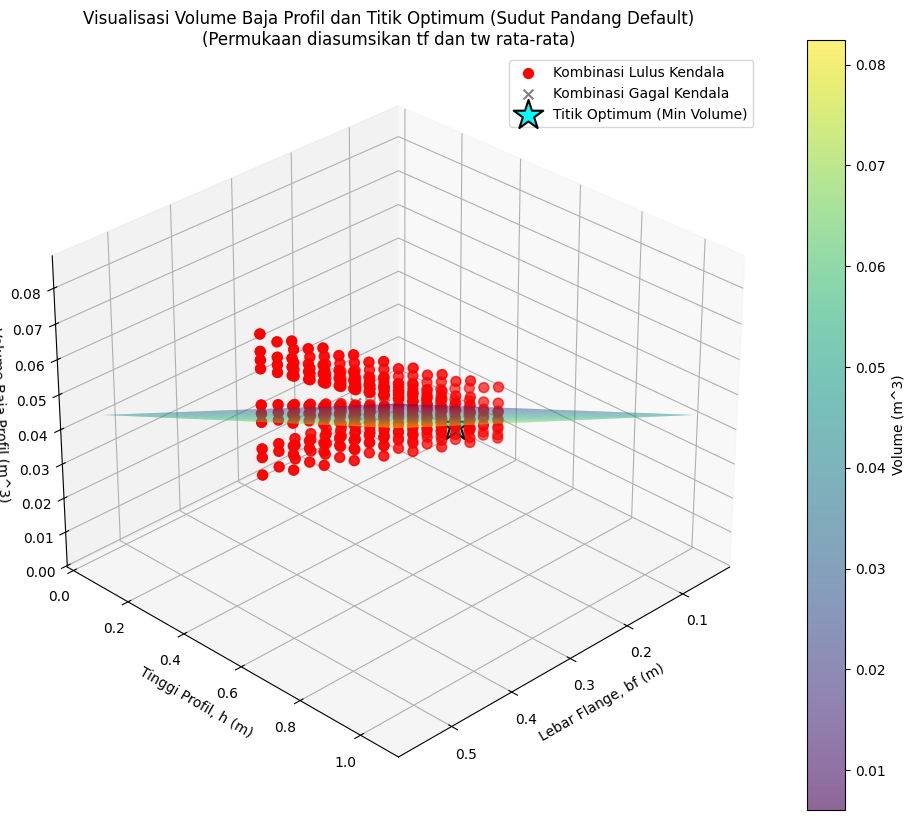

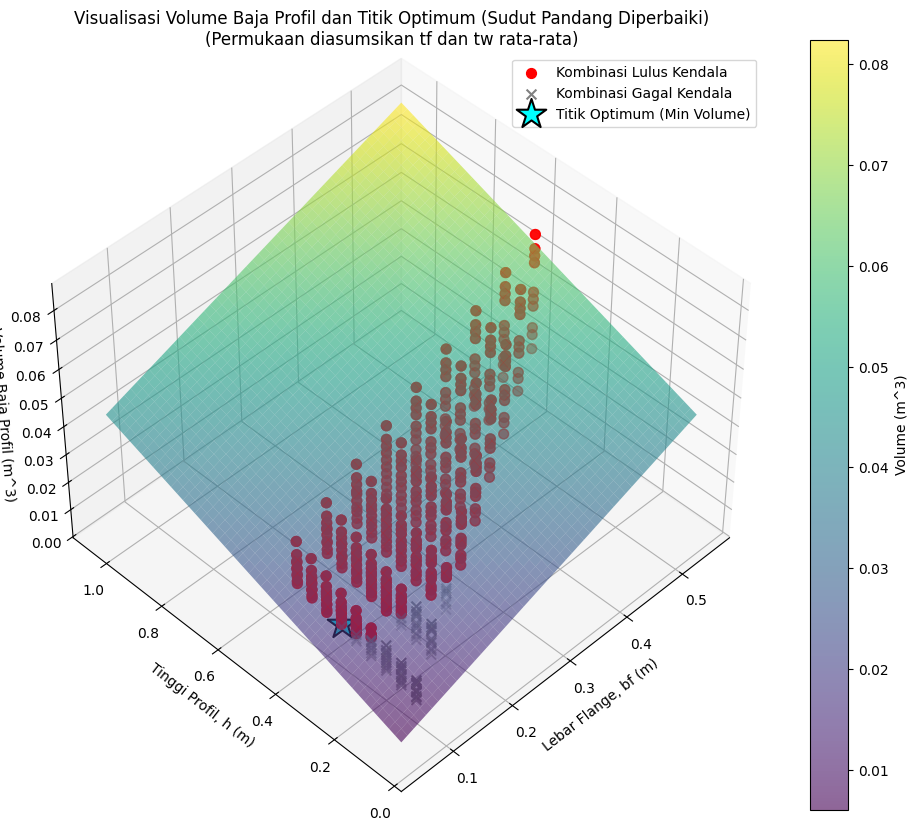

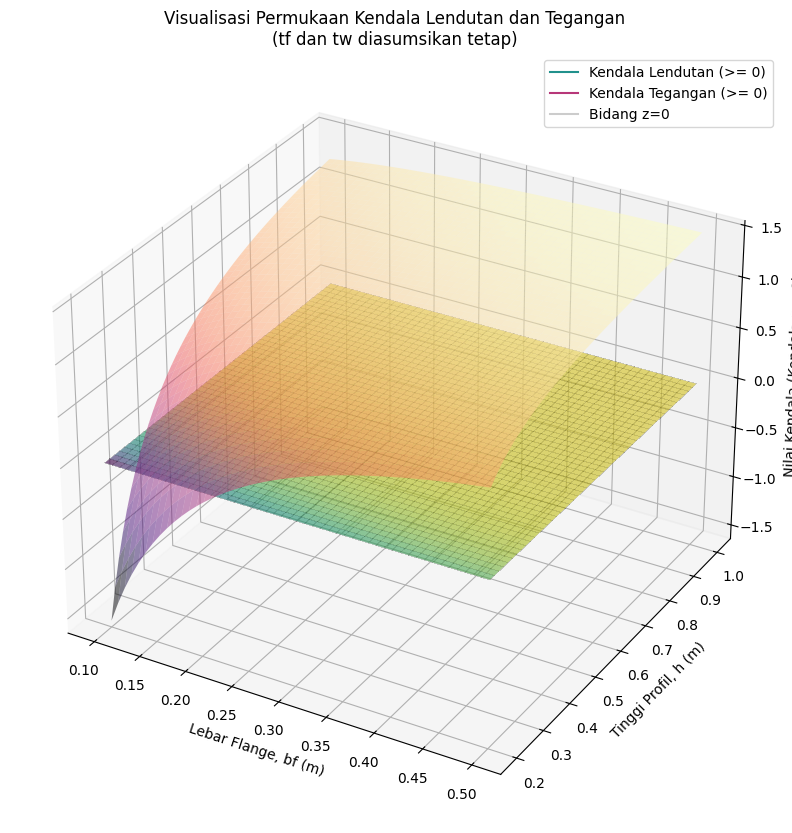

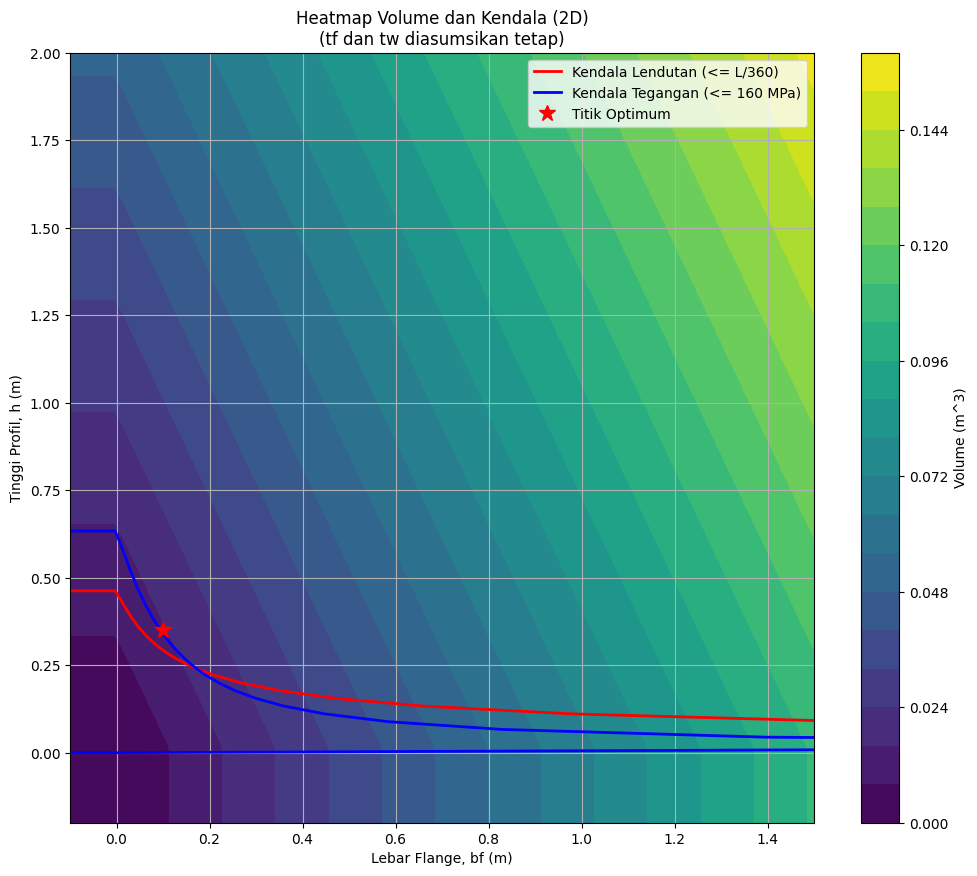

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
import matplotlib.cm as cm # Masih diperlukan jika ada kode lain yang memakainya, tapi tidak lagi untuk get_cmap
import logging

# --- 0. Global Constants ---
# Material Properties
E = 200 * (10**9)   # N/m^2 (Modulus Elastisitas Baja)
sigma_izin = 160 * (10**6)   # N/m^2 (Tegangan Izin Baja)
density_steel = 7850   # kg/m^3 (Densitas Baja)

# Loading and Geometry (KONSTAN)
P = 40000     # N (Beban Terpusat: 500 kg = 5000 N)
L = 5.0      # m (Bentang Balok: KONSTAN 3.0 m)

# Numerical Stability Constant
EPSILON = 1e-9

# --- 1. Helper Functions for IWF Properties ---
# Fungsi-fungsi ini menghitung properti penampang IWF, DITINGKATKAN untuk menangani input array
def calculate_I_x(h, bf, tf, tw):
    """Menghitung Momen Inersia (Ix) untuk penampang IWF.
    Ditingkatkan untuk menangani input array (menggunakan np.where).
    """
    # Pastikan semua dimensi efektif adalah non-negatif, menggunakan np.where untuk operasi element-wise
    h_eff = np.where(h <= EPSILON, EPSILON, h)
    bf_eff = np.where(bf <= EPSILON, EPSILON, bf)
    tf_eff = np.where(tf <= EPSILON, EPSILON, tf)
    tw_eff = np.where(tw <= EPSILON, EPSILON, tw)

    I_x_flange_centroid = (1/12) * bf_eff * tf_eff**3
    A_flange = bf_eff * tf_eff
    y_flange = (h_eff/2) - (tf_eff/2)
    I_x_flange = 2 * (I_x_flange_centroid + A_flange * y_flange**2)

    # Tinggi web juga bisa negatif secara matematis, pastikan non-negatif secara element-wise
    web_height = h_eff - 2*tf_eff
    # Hitung I_x_web, tapi set ke 0 jika tinggi web non-positif
    I_x_web_val = (1/12) * tw_eff * (web_height)**3
    I_x_web = np.where(web_height <= EPSILON, 0, I_x_web_val)

    # Pastikan hasil akhir Ix juga non-negatif
    return np.where((I_x_flange + I_x_web) <= EPSILON, EPSILON, (I_x_flange + I_x_web))

def calculate_W_z(h, I_x_val):
    """Menghitung Modulus Penampang (Wz) untuk penampang IWF.
    Ditingkatkan untuk menangani input array (menggunakan np.where).
    """
    # Pastikan h efektif non-negatif
    h_eff = np.where(h <= EPSILON, EPSILON, h)
    # Pastikan I_x_val efektif non-negatif (jika datang dari calculate_I_x yang di-robust)
    I_x_val_eff = np.where(I_x_val <= EPSILON, EPSILON, I_x_val)

    Wz = I_x_val_eff / (h_eff / 2)
    # Pastikan hasil akhir Wz juga non-negatif
    return np.where(Wz <= EPSILON, EPSILON, Wz)

def calculate_area(h, bf, tf, tw):
    """Menghitung luas penampang (A) untuk penampang IWF.
    Ditingkatkan untuk menangani input array (menggunakan np.where).
    """
    web_height = h - 2*tf
    effective_web_height = np.where(web_height < 0, 0, web_height)
    bf_eff = np.where(bf < 0, 0, bf)
    tf_eff = np.where(tf < 0, 0, tf)
    tw_eff = np.where(tw < 0, 0, tw)
    return 2 * (bf_eff * tf_eff) + (effective_web_height) * tw_eff

# --- 2. Objective Function ---
def objective_function(params):
    """Fungsi objektif untuk diminimalkan (Volume balok)."""
    h, bf, tf, tw = params
    area = calculate_area(h, bf, tf, tw)
    volume = area * L
    return volume

# --- 3. Constraint Functions ---
# Fungsi kendala ini telah dimodifikasi untuk menangani input array secara element-wise
# yang diperlukan untuk visualisasi permukaan kendala.
def deflection_constraint(params):
    """Kendala Lendutan: delta_actual <= delta_izin. Mengembalikan nilai >= 0 jika kendala terpenuhi."""
    h, bf, tf, tw = params
    I_x_val = calculate_I_x(h, bf, tf, tw)

    # Gunakan np.where untuk memastikan pembagian dengan I_x_val yang valid
    # serta menangani kasus di mana I_x_val sangat kecil (mendekati nol)
    delta_actual = np.where(I_x_val <= EPSILON, np.inf, (P * L**3) / (48 * E * I_x_val))
    delta_izin = L / 360
    return delta_izin - delta_actual

def stress_constraint(params):
    """Kendala Tegangan Lentur: sigma_actual <= sigma_izin. Mengembalikan nilai >= 0 jika kendala terpenuhi."""
    h, bf, tf, tw = params
    I_x_val = calculate_I_x(h, bf, tf, tw)
    W_z_val = calculate_W_z(h, I_x_val)

    # Gunakan np.where untuk memastikan pembagian dengan W_z_val yang valid
    # serta menangani kasus di mana W_z_val sangat kecil (mendekati nol)
    M_max = (P * L) / 4
    sigma_actual = np.where(W_z_val <= EPSILON, np.inf, M_max / W_z_val)
    return sigma_izin - sigma_actual

# Validasi kendala
def validate_constraints(params):
    """Validasi kendala untuk memastikan bahwa semua kendala terpenuhi."""
    deflection_ok = deflection_constraint(params) >= 0
    stress_ok = stress_constraint(params) >= 0
    return deflection_ok and stress_ok

# --- Fungsi untuk menghasilkan semua kombinasi (Data Sebelum Optimasi) ---
def get_pre_optimization_data():
    """
    Menghasilkan semua kombinasi parameter h, bf, tf, tw yang valid
    berdasarkan batasan diskrit dan geometri awal, sebelum kendala struktural.
    """
    # Menentukan nilai diskrit untuk setiap parameter (konversi mm ke meter)
    h_values = np.array([100, 150, 200, 250, 300, 350, 400, 450, 500]) * 1e-3
    bf_values = np.array([100, 150, 200, 250, 300, 350, 400, 450, 500]) * 1e-3
    t_values = np.array([5, 6, 7, 9, 12]) * 1e-3 # Untuk tf dan tw

    pre_optimization_combinations = []

    # Iterasi melalui setiap kombinasi yang mungkin (Pembentukan Grid)
    for h in h_values:
        for bf in bf_values:
            # Kendala Geometri 1: bf tidak boleh lebih besar dari h
            if bf > h:
                continue

            for tf in t_values:
                for tw in t_values:
                    # Kendala Geometri 2: tf harus lebih besar dari tw
                    if tf <= tw:
                        continue

                    # Kendala Geometri 3: Tinggi web harus positif
                    if (h - 2*tf) <= EPSILON:
                        continue

                    current_params = (h, bf, tf, tw)
                    # Kita bisa juga langsung hitung volumenya di sini
                    current_volume = objective_function(current_params)
                    pre_optimization_combinations.append({
                        'h': current_params[0],
                        'bf': current_params[1],
                        'tf': current_params[2],
                        'tw': current_params[3],
                        'volume': current_volume
                    })
    return pre_optimization_combinations


# --- 4. Grid Generation and Search ---
def grid_search_optimization():
    """
    Melakukan optimasi balok IWF menggunakan metode Grid Search.
    """
    # Menentukan nilai diskrit untuk setiap parameter
    # Konversi dari mm ke meter (x 1e-3)
    h_values = np.array([100, 150, 200, 250, 300, 350, 400, 450, 500]) * 1e-3
    bf_values = np.array([100, 150, 200, 250, 300, 350, 400, 450, 500]) * 1e-3
    t_values = np.array([5, 6, 7, 9, 12]) * 1e-3 # Untuk tf dan tw

    all_combinations = []
    passing_combinations = []
    best_volume = float('inf')
    best_combo = None

    print("Memulai Grid Search...")
    total_combinations_checked = 0

    # Iterasi melalui setiap kombinasi yang mungkin (Pembentukan Grid)
    for h in h_values:
        for bf in bf_values:
            # Kendala Geometri 1: bf tidak boleh lebih besar dari h
            if bf > h:
                continue

            for tf in t_values:
                for tw in t_values:
                    # Kendala Geometri 2: tf harus lebih besar dari tw
                    if tf <= tw:
                        continue

                    # Pastikan tinggi web positif secara fisik untuk kombinasi skalar ini
                    if (h - 2*tf) <= EPSILON:
                        continue

                    current_params = [h, bf, tf, tw]
                    all_combinations.append(current_params)
                    total_combinations_checked += 1

                    # --- Evaluasi Kendala untuk Kombinasi Saat Ini ---
                    # Catatan: Fungsi kendala ini akan dipanggil dengan skalar dalam konteks ini
                    deflection_ok = deflection_constraint(current_params) >= 0
                    stress_ok = stress_constraint(current_params) >= 0

                    if validate_constraints(current_params):
                        passing_combinations.append(current_params)
                        current_volume = objective_function(current_params)
                        if current_volume < best_volume:
                            best_volume = current_volume
                            best_combo = current_params

                    if deflection_ok and stress_ok:
                        passing_combinations.append(current_params)

                        # --- Evaluasi Fungsi Objektif dan Cari yang Terbaik ---
                        current_volume = objective_function(current_params) # Akan menerima skalar
                        if current_volume < best_volume:
                            best_volume = current_volume
                            best_combo = current_params

    print(f"\nTotal kombinasi yang diperiksa di grid: {total_combinations_checked}")
    print(f"Jumlah kombinasi yang lolos semua kendala: {len(passing_combinations)}")

    if best_combo:
        assert validate_constraints(best_combo), "Solusi optimum tidak memenuhi kendala!"
        print("\n--- Hasil Optimasi Grid Search ---")
        print(f"Dimensi Profil Optimum (Volume Minimum):")
        print(f"  Tinggi (h): {best_combo[0]*1000:.2f} mm")
        print(f"  Lebar Flange (bf): {best_combo[1]*1000:.2f} mm")
        print(f"  Tebal Flange (tf): {best_combo[2]*1000:.2f} mm")
        print(f"  Tebal Web (tw): {best_combo[3]*1000:.2f} mm")
        print(f"Volume Baja Minimum: {best_volume:.6f} m^3")
    else:
        print("\nTidak ada kombinasi yang ditemukan yang memenuhi semua kendala.")

    return all_combinations, passing_combinations, best_combo, best_volume

# --- Tampilkan Data Sebelum Optimasi ---
if __name__ == "__main__":
    pre_opt_data = get_pre_optimization_data()

    print(f"Ditemukan {len(pre_opt_data)} kombinasi profil IWF sebelum optimasi (setelah filter geometri awal).\n")
    print("--- 10 Kombinasi Pertama ---")
    for i, combo in enumerate(pre_opt_data[:10]):
        print(f"Kombinasi {i+1}: "
              f"h={combo['h']*1000:.1f}mm, "
              f"bf={combo['bf']*1000:.1f}mm, "
              f"tf={combo['tf']*1000:.1f}mm, "
              f"tw={combo['tw']*1000:.1f}mm, "
              f"Volume={combo['volume']:.6f} m^3")

    print("\n--- 10 Kombinasi Terakhir ---")
    for i, combo in enumerate(pre_opt_data[-10:]):
        print(f"Kombinasi {len(pre_opt_data)-10+i+1}: "
              f"h={combo['h']*1000:.1f}mm, "
              f"bf={combo['bf']*1000:.1f}mm, "
              f"tf={combo['tf']*1000:.1f}mm, "
              f"tw={combo['tw']*1000:.1f}mm, "
              f"Volume={combo['volume']:.6f} m^3")


# --- 4. Jalankan Grid Search untuk Optimasi ---    
# Jalankan proses optimasi
all_combos_for_plot, passing_combos_for_plot, optimal_combo, optimal_volume = grid_search_optimization()

# --- 5. Visualisasi Hasil Grid Search ---
# Filter data untuk visualisasi: hanya menggunakan h dan bf sebagai sumbu permukaan 3D
# Buat rentang nilai untuk bf dan h (untuk permukaan asumsi tf/tw tetap)
bf_surface_range = np.linspace(0.05, 0.55, 50)
h_surface_range = np.linspace(0.05, 1.05, 50)

# Asumsi nilai tf dan tw yang tetap untuk simplifikasi visualisasi permukaan
# Kita bisa ambil nilai rata-rata atau median dari t_values
tf_fixed_surface = np.mean(np.array([5, 6, 7, 9, 12]) * 1e-3)
tw_fixed_surface = np.mean(np.array([5, 6, 7, 9, 12]) * 1e-3)

BF_SURF, H_SURF = np.meshgrid(bf_surface_range, h_surface_range)
# Panggilan ke objective_function ini sekarang akan menerima array H_SURF, BF_SURF, dll.
# Fungsi-fungsi pembantu telah dimodifikasi untuk menangani ini.
VOLUME_SURF = objective_function([H_SURF, BF_SURF, np.full_like(BF_SURF, tf_fixed_surface), np.full_like(BF_SURF, tw_fixed_surface)])


# --- Gambar 1: Dengan Sudut Pandang Default (atau sebelumnya) ---
fig1 = plt.figure(figsize=(12, 10))
ax1 = fig1.add_subplot(111, projection='3d')

surf1 = ax1.plot_surface(BF_SURF, H_SURF, VOLUME_SURF, cmap='viridis', edgecolor='none', alpha=0.6)

if passing_combos_for_plot:
    passing_h_plot = [c[0] for c in passing_combos_for_plot]
    passing_bf_plot = [c[1] for c in passing_combos_for_plot]
    passing_volumes_plot = [objective_function(c) for c in passing_combos_for_plot]
    ax1.scatter(passing_bf_plot, passing_h_plot, passing_volumes_plot, c='red', marker='o', s=50, label='Kombinasi Lulus Kendala')

# Tambahkan kombinasi yang gagal memenuhi kendala
failing_combos = [c for c in all_combos_for_plot if not validate_constraints(c)]
if failing_combos:
    failing_h_plot = [c[0] for c in failing_combos]
    failing_bf_plot = [c[1] for c in failing_combos]
    failing_volumes_plot = [objective_function(c) for c in failing_combos]
    ax1.scatter(failing_bf_plot, failing_h_plot, failing_volumes_plot, c='gray', marker='x', s=50, label='Kombinasi Gagal Kendala')
    
if optimal_combo:
    opt_h, opt_bf, opt_tf, opt_tw = optimal_combo
    opt_volume = optimal_volume
    ax1.scatter(opt_bf, opt_h, opt_volume, c='cyan', marker='*', s=500, label='Titik Optimum (Min Volume)', edgecolor='black', linewidth=1.5)

ax1.set_xlabel('Lebar Flange, bf (m)')
ax1.set_ylabel('Tinggi Profil, h (m)')
ax1.set_zlabel('Volume Baja Profil (m^3)')
ax1.set_title('Visualisasi Volume Baja Profil dan Titik Optimum (Sudut Pandang Default)\n(Permukaan diasumsikan tf dan tw rata-rata)')

fig1.colorbar(surf1, label='Volume (m^3)')
ax1.legend()
ax1.view_init(elev=30, azim=45) # Sudut pandang default/sebelumnya
plt.show()

# --- Gambar 2: Dengan Sudut Pandang yang Diperbaiki ---
fig2 = plt.figure(figsize=(12, 10))
ax2 = fig2.add_subplot(111, projection='3d')

surf2 = ax2.plot_surface(BF_SURF, H_SURF, VOLUME_SURF, cmap='viridis', edgecolor='none', alpha=0.6)

if passing_combos_for_plot:
    passing_h_plot = [c[0] for c in passing_combos_for_plot]
    passing_bf_plot = [c[1] for c in passing_combos_for_plot]
    passing_volumes_plot = [objective_function(c) for c in passing_combos_for_plot]
    ax2.scatter(passing_bf_plot, passing_h_plot, passing_volumes_plot, c='red', marker='o', s=50, label='Kombinasi Lulus Kendala')

# Tambahkan kombinasi yang gagal memenuhi kendala
failing_combos = [c for c in all_combos_for_plot if not validate_constraints(c)]
if failing_combos:
    failing_h_plot = [c[0] for c in failing_combos]
    failing_bf_plot = [c[1] for c in failing_combos]
    failing_volumes_plot = [objective_function(c) for c in failing_combos]
    ax2.scatter(failing_bf_plot, failing_h_plot, failing_volumes_plot, c='gray', marker='x', s=50, label='Kombinasi Gagal Kendala')
    

if optimal_combo:
    opt_h, opt_bf, opt_tf, opt_tw = optimal_combo
    opt_volume = optimal_volume
    ax2.scatter(opt_bf, opt_h, opt_volume, c='cyan', marker='*', s=500, label='Titik Optimum (Min Volume)', edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Lebar Flange, bf (m)')
ax2.set_ylabel('Tinggi Profil, h (m)')
ax2.set_zlabel('Volume Baja Profil (m^3)')
ax2.set_title('Visualisasi Volume Baja Profil dan Titik Optimum (Sudut Pandang Diperbaiki)\n(Permukaan diasumsikan tf dan tw rata-rata)')

fig2.colorbar(surf2, label='Volume (m^3)')
ax2.legend()
ax2.view_init(elev=45, azim=225) # Sudut pandang yang diperbaiki
plt.show()

# --- 5. Visualisasi Tambahan ---
# a. Visualisasi Permukaan Kendala
def visualize_constraint_surfaces(tf_fixed, tw_fixed):
    """Memvisualisasikan permukaan kendala lendutan dan tegangan."""
    bf_range = np.linspace(0.1, 0.5, 50)  # Rentang lebar flange (m)
    h_range = np.linspace(0.2, 1.0, 50)  # Rentang tinggi profil (m)
    BF, H = np.meshgrid(bf_range, h_range)

    # Hitung nilai kendala untuk setiap kombinasi h dan bf
    # Fungsi kendala sekarang robust terhadap input array
    deflection = deflection_constraint([H, BF, np.full_like(BF, tf_fixed), np.full_like(BF, tw_fixed)])
    stress = stress_constraint([H, BF, np.full_like(BF, tf_fixed), np.full_like(BF, tw_fixed)])

    # Plot 3D
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot permukaan kendala lendutan
    ax.plot_surface(BF, H, deflection, cmap='viridis', alpha=0.5)
    # Plot permukaan kendala tegangan
    ax.plot_surface(BF, H, stress, cmap='magma', alpha=0.5)

    # Atur label sumbu
    ax.set_xlabel('Lebar Flange, bf (m)')
    ax.set_ylabel('Tinggi Profil, h (m)')
    ax.set_zlabel('Nilai Kendala (Kendala >= 0)')
    ax.set_title('Visualisasi Permukaan Kendala Lendutan dan Tegangan\n(tf dan tw diasumsikan tetap)')

    # Tambahkan bidang z=0 untuk membantu interpretasi
    ax.plot_surface(BF, H, np.zeros_like(BF), color='black', alpha=0.2, linewidth=0, antialiased=False)

    # Ambil warna dari colormap menggunakan plt.colormaps
    viridis_color = plt.colormaps['viridis'](0.5) # Ambil warna dari tengah colormap viridis
    magma_color = plt.colormaps['magma'](0.5)   # Ambil warna dari tengah colormap magma

    # Tambahkan dummy plot untuk legend dengan warna tunggal dari colormap
    ax.plot([], [], color=viridis_color, label='Kendala Lendutan (>= 0)')
    ax.plot([], [], color=magma_color, label='Kendala Tegangan (>= 0)')
    ax.plot([], [], color='black', alpha=0.2, label='Bidang z=0') # Dummy label for z=0 plane
    ax.legend()

    plt.show()

# b. Heatmap Proyeksi Volume dan Kendala (2D)
def visualize_volume_and_constraints_2d(tf_fixed, tw_fixed):
    """Memvisualisasikan volume dan kendala dalam plot 2D (heatmap)."""
    bf_range = np.linspace(-0.1, 1.5, 100)  # Rentang lebar flange (m)
    h_range = np.linspace(-0.2, 2.0, 100)  # Rentang tinggi profil (m)
    BF, H = np.meshgrid(bf_range, h_range)

    # Hitung volume dan nilai kendala
    volume = objective_function([H, BF, np.full_like(BF, tf_fixed), np.full_like(BF, tw_fixed)])
    deflection = deflection_constraint([H, BF, np.full_like(BF, tf_fixed), np.full_like(BF, tw_fixed)])
    stress = stress_constraint([H, BF, np.full_like(BF, tf_fixed), np.full_like(BF, tw_fixed)])

    # Buat plot 2D
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot heatmap volume
    contour = ax.contourf(BF, H, volume, levels=20, cmap='viridis')
    cbar = fig.colorbar(contour, label='Volume (m^3)')

    # Tumpang tindihkan kontur kendala
    # Hanya plot kontur di mana nilai kendala sama dengan nol
    # Gunakan np.nan_to_num untuk mengatasi np.inf dari kendala yang tidak terpenuhi
    ax.contour(BF, H, np.nan_to_num(deflection, nan=1e10, posinf=1e10, neginf=-1e10), levels=[0], colors='red', linewidths=2)
    ax.contour(BF, H, np.nan_to_num(stress, nan=1e10, posinf=1e10, neginf=-1e10), levels=[0], colors='blue', linewidths=2)

    # Tandai titik optimum (jika ada)
    if optimal_combo:
        ax.plot(optimal_combo[1], optimal_combo[0], 'r*', markersize=12, label='Titik Optimum')

    # Atur label dan judul
    ax.set_xlabel('Lebar Flange, bf (m)')
    ax.set_ylabel('Tinggi Profil, h (m)')
    ax.set_title('Heatmap Volume dan Kendala (2D)\n(tf dan tw diasumsikan tetap)')
    ax.legend(handles=[plt.Line2D([0], [0], color='red', lw=2, label='Kendala Lendutan (<= L/360)'),
                       plt.Line2D([0], [0], color='blue', lw=2, label='Kendala Tegangan (<= 160 MPa)'),
                       plt.Line2D([0], [0], marker='*', color='r', markersize=12, linestyle='None', label='Titik Optimum')])
    ax.grid(True)
    plt.show()


# Contoh penggunaan visualisasi
# Gunakan nilai tf dan tw yang representatif, misalnya dari hasil optimum jika tersedia,
# atau nilai rata-rata/median dari t_values Anda.
tf_fixed_example = optimal_combo[2] if optimal_combo else np.mean(np.array([5, 6, 7, 9, 12]) * 1e-3)
tw_fixed_example = optimal_combo[3] if optimal_combo else np.mean(np.array([5, 6, 7, 9, 12]) * 1e-3)

visualize_constraint_surfaces(tf_fixed_example, tw_fixed_example)
visualize_volume_and_constraints_2d(tf_fixed_example, tw_fixed_example)